## Linear Blend Skinning

Implementation of a 2D linear blend skinning (LBS) algorithm.

##  Geometry

### Create Geometry

This code creates a grid mesh.<br>
An example of with cell_x(3) and cell_y(2):<br>
|8 .. 9 .. 10 .. 11|<br>
|4 .. 5 .. 6  .. 7 |<br>
|0 .. 1 .. 2  .. 3 |

In [1]:
import numpy as np

class Mesh:
    def __init__(self, vertices, indices):
        self.vertices = vertices
        self.indices = indices

def create_mesh(min_x, min_y, max_x, max_y, cell_x, cell_y):
    num_vertices = (cell_x + 1) * (cell_y + 1)
    vertices = np.zeros((num_vertices,2))

    # Set vertices
    vertex_id = 0
    x = np.linspace(min_x, max_x, num=cell_x+1, endpoint=True)
    y = np.linspace(min_y, max_y, num=cell_y+1, endpoint=True)
    
    # Set grid   
    for j in range(cell_y+1):
        for i in range(cell_x+1):
            vertices[vertex_id] = (x[i], y[j])
            vertex_id += 1

    # Set edges
    c_id = lambda i, j: i + (j*(cell_x+1))
    edges = []
    for j in range(cell_y):
        edges.append([c_id(0, j), c_id(0, j+1)])
        edges.append([c_id(cell_x, j), c_id(cell_x, j+1)])

    for i in range(cell_x):
        edges.append([c_id(i, 0), c_id(i+1, 0)])
        edges.append([c_id(i, cell_y), c_id(i+1, cell_y)])
    edges = np.array(edges, dtype=int)

    return Mesh(vertices, edges)

mesh = create_mesh(-7, -1, 7, 1, 20, 2)

### Draw geometry

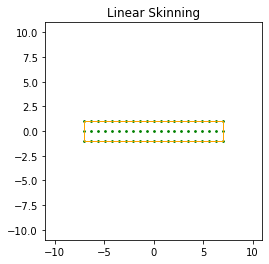

In [2]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def reset_ax(ax):
    ax.clear()
    ax.set_aspect('equal')
    ax.set_xlim(-11, 11)
    ax.set_ylim(-11, 11)

def create_figure():
    fig, ax = plt.subplots()
    reset_ax(ax)
    plt.title('Linear Skinning')
    return fig, ax
    
def draw_mesh(ax, mesh):
    # Draw vertices
    x, y = zip(*mesh.vertices)
    ax.scatter(x, y, color='green', s=3.0)
    # Draw edges
    segments = mesh.vertices[mesh.indices]
    line_segments = LineCollection(segments,
                               linewidths=1.0,
                               colors='orange',
                               linestyles='-',
                               alpha=1.0)
    ax.add_collection(line_segments)

_, ax = create_figure()
draw_mesh(ax, mesh)
plt.show()

## Skeleton

### Create bone

Bone transformed are stored using a **homogenous transformation**.

In [3]:
class Bone:
    def __init__(self, length = 1.0, rotation = 0.0):
        self.length = length # bone length
        self.rotation = rotation # rotation in degrees
        self.bone_children = [] # children

    def get_transform(self):
        '''
        3x3 Matrix combining rotation and displacement
        where R is 2x2 rotation matrix
        and d is 2d vector
        | R  d |
        | 0  1 |
        '''
        cos = np.cos(np.deg2rad(self.rotation))
        sin = np.sin(np.deg2rad(self.rotation))
        H = np.asarray(
            [[cos, -sin, cos * self.length],
             [sin, cos, sin * self.length],
             [0, 0, 1]])
        return H

### Create skeleton 

In [4]:
class Skeleton:
    def __init__(self, skeleton_position, root_bone):
        self.skeleton_position = skeleton_position
        self.root_bone = root_bone
        self.bones = []
        self.bone_transforms = None

    def add_bone(self, bone, bone_parent = None):
        self.bones.append(bone)
        if bone_parent:
            bone_parent.bone_children.append(bone)

    def get_skeleton_transform(self):
        # global transformation of the skeleton
        H = np.identity(3)
        H[0:2,2] = self.skeleton_position
        return H

    def update_bone_transforms(self):
        num_bones = len(self.bones)
        self.bone_transforms = np.zeros((num_bones,3,3))
        
        global_t = self.get_skeleton_transform()
        bone_id = 0
        bone = self.root_bone
        while bone is not None:
            # Concatenate transformation matrix
            global_t = np.matmul(global_t, bone.get_transform())

            # Go to the children
            if len(bone.bone_children) > 0:
                # TODO : make sure to handle multiple children
                bone = bone.bone_children[0]
            else:
                bone = None

            self.bone_transforms[bone_id] = global_t
            bone_id += 1

    def get_bone_segments(self):
        rest = np.asarray([0, 0, 1])
        self.update_bone_transforms()

        segments = []
        prev_pos = np.matmul(self.get_skeleton_transform(), rest)
        for bone_t in self.bone_transforms:
            next_pos = np.matmul(bone_t, rest)
            segments.append([prev_pos[0:2], next_pos[0:2]])
            prev_pos = next_pos

        return segments

In [5]:
def create_skeleton_with_4_bones():
    root_bone = Bone(length = 3.0, rotation = 0.0)
    bone1 = Bone(length = 3.0, rotation = 0.0)
    bone2 = Bone(length = 3.0, rotation = 0.0)
    bone3 = Bone(length = 3.0, rotation = 0.0)

    skeleton = Skeleton(np.asarray([-6.0, 0.0]), root_bone)
    skeleton.add_bone(root_bone)
    skeleton.add_bone(bone1, root_bone)
    skeleton.add_bone(bone2, bone1)
    skeleton.add_bone(bone3, bone2)

    return skeleton

skeleton = create_skeleton_with_4_bones()

### Draw skeleton

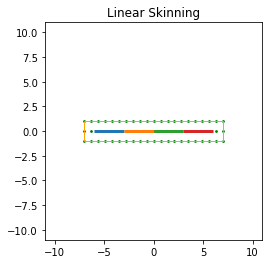

In [6]:
from matplotlib import colors as mcolors
def get_colors_template():
    return np.asarray([mcolors.to_rgba(c) \
                       for c in plt.rcParams['axes.prop_cycle'].by_key()['color']])

def draw_skeleton(ax, skeleton):
    segments = skeleton.get_bone_segments()
    colors_template = get_colors_template()
    line_segments = LineCollection(segments,
                                   linewidths=3.0,
                                   colors=colors_template,
                                   linestyles='-',
                                   alpha=1.0)

    ax.add_collection(line_segments)
    
_, ax = create_figure()
draw_skeleton(ax, skeleton)
draw_mesh(ax, mesh)
plt.show()

## Animate Skeleton

In [7]:
class Animator:
    def __init__(self, skeleton):
        self.skeleton = skeleton
        self.bone_animators = [] # Lambda function
        rotations = np.linspace(20.0, 36.0, len(self.skeleton.bones), endpoint=True)
        for i, bone in enumerate(self.skeleton.bones):
            func = lambda time : np.sin(time / 2.0 * np.pi) * rotations[i]
            self.bone_animators.append(func)

    def animate(self, time):
        # animate the skeleton
        for i, anim in enumerate(self.bone_animators):
            bone = self.skeleton.bones[i]
            bone.rotation = anim(time)

        # make sure the skeleton matrices are up-to-date
        self.skeleton.update_bone_transforms()
    
animator = Animator(skeleton)

## Skinning

Skinning algorithm consists in deforming the template mesh based on the bone transformations.
- ${v}'_{i}$ is a transformed vertex
- $v_{i}$ is the vertex in bind pose
- $w_{ij}$ is the vertex weight
- $B_{j}$ is the local to world transform for the bind pose
- $B_{j}^{-1}$ is the world to local transform for the bind pose
- $r_{i}$ is the rest vertex where $r_{i}=B^{-1}_{i}v_{i}$
- $T_{j}$ is the local to world tranform for the animated pose

$${v}'_{i}=\sum_{j=1}^{m}w_{ij}T_{j}(B^{-1}_{i}v_{i})=\sum_{j=1}^{m}w_{ij}T_{j}r_{i}$$


### Compute influences

In [8]:
# Weight function settings
KERNEL_PARAMETER = 1.0
KERNEL_FUNCTION = lambda v : np.exp(-np.square((v * KERNEL_PARAMETER)))
BIDDING_MAX_INFLUENCES = 2

# TODO : show the influence function

In [9]:
def distance_from_segment(p, seg_p1, seg_p2):
    d = seg_p2 - seg_p1
    d_norm = np.linalg.norm(d)
    d_normalized = d / d_norm
    t = np.dot(p - seg_p1, d_normalized)
    t = min(max(t, 0.0), d_norm)
    projected_p = seg_p1 + d_normalized * t
    return np.linalg.norm(p - projected_p)

class LinearBlendSkinning:

    def __init__(self, mesh, skeleton, max_influences, kernel_func):
        num_bones = len(skeleton.bones)
        num_vertices = len(mesh.vertices) 
        num_influences = min(num_bones, max_influences)

        # Keep a reference on the mesh and skeleton
        self.mesh = mesh
        self.skeleton = skeleton

        # Preallocate skinning data
        self.weights = np.zeros((num_influences, num_vertices))
        self.bone_ids = np.zeros((num_influences, num_vertices), dtype=int)
        self.rest_vertices = np.zeros((num_influences, num_vertices, 3))

        # Compute weights per vertices per bones
        bone_segments = self.skeleton.get_bone_segments()      
        for i in range(num_vertices):
            vertex = self.mesh.vertices[i]
            bone_weights = np.zeros(num_bones)
            for bone_id, bone_seg in enumerate (bone_segments):  
                distance = distance_from_segment(vertex, bone_seg[0], bone_seg[1])
                bone_weights[bone_id] = kernel_func(distance)

            weigths_sorted_index = np.argsort(bone_weights)
            self.bone_ids[:,i] = weigths_sorted_index[-1:-(num_influences+1):-1]
            self.weights[:,i] = bone_weights[self.bone_ids[:,i]]
            self.weights[:,i] /= np.sum(self.weights[:,i])

        # Auxiliary variables to store the homogeneous vertices and inverse transformations
        homogenous_vertices = np.ones((num_vertices, 3))
        homogenous_vertices[:, 0:2] = self.mesh.vertices
        rest_inv_transforms = np.zeros((num_bones,3,3))
        for bone_id, bone_transform in enumerate(self.skeleton.bone_transforms):
            rest_inv_transforms[bone_id] = np.linalg.inv(bone_transform)

        # Store the rest vertices
        for j in range(num_influences):
            for i in range(num_vertices):
                bone_id = self.bone_ids[j][i]
                invB = rest_inv_transforms[bone_id]
                T = self.skeleton.bone_transforms[bone_id]
                self.rest_vertices[j][i] = np.matmul(invB, homogenous_vertices[i])

    def update_mesh(self):        
        num_influences = self.weights.shape[0]
        num_vertices = self.weights.shape[1]

        self.mesh.vertices.fill(0)
        for j in range(num_influences):
            v = self.rest_vertices[j,:] * np.expand_dims(self.weights[j], axis=1)
            T = self.skeleton.bone_transforms[self.bone_ids[j]]
            #self.mesh.vertices += np.einsum('fid,fi->fd',T,v)[:,:2] #- TODO - use einsum instead of explicit loop
            for i in range(num_vertices):
                v_i = np.dot(T[i], v[i])
                self.mesh.vertices[i] += v_i[0:2]
    
linear_blend_skinning = LinearBlendSkinning(mesh, skeleton, BIDDING_MAX_INFLUENCES, KERNEL_FUNCTION)

### Draw influences

In order to draw the influences, we will override the mesh function to draw the influences

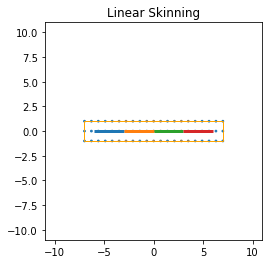

In [10]:
def draw_mesh_and_influences(ax, mesh, weights):
    # compute point colors
    colors_template = get_colors_template()
    point_colors = np.zeros((len(mesh.vertices), 4))
    point_colors[:,3] = 1   
    num_influences = weights.shape[0]
    num_vertices = weights.shape[1]
    for i in range(num_vertices):
        # TODO - also this code doesn't work !
        for j in range(num_influences):
            weight = weights[j, i]
            point_colors[i][0:3] += colors_template[j][0:3] * weight
   
    # draw vertices
    x, y = zip(*mesh.vertices)
    ax.scatter(x, y, color=point_colors, s=3.0)
    # draw edges
    segments = mesh.vertices[mesh.indices]
    line_segments = LineCollection(segments,
                               linewidths=1.0,
                               colors='orange',
                               linestyles='-',
                               alpha=1.0)
    ax.add_collection(line_segments)
    
_, ax = create_figure()
draw_mesh_and_influences(ax, mesh, linear_blend_skinning.weights)
draw_skeleton(ax, skeleton)
plt.show()

### Skinning Algorithm

In [11]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Sequence settings
NUM_FRAMES = 25
FRAME_TIME_STEP = 1.0 / 24.0

# Create figure
fig, ax = create_figure()

# Create an animation from results
def update_figure(frame_num):
    reset_ax(ax)
    animator.animate(frame_num * FRAME_TIME_STEP)
    linear_blend_skinning.update_mesh()
    draw_mesh_and_influences(ax, mesh, linear_blend_skinning.weights)
    draw_skeleton(ax, skeleton)
    
plt.close()
anim = FuncAnimation(fig, update_figure, frames=NUM_FRAMES, interval=40)
HTML(anim.to_jshtml(default_mode='Reflect'))

## Further Reading

- Magnenat-Thalmann, Nadia, Richard Laperrire, and Daniel Thalmann. "Joint-dependent local deformations for hand animation and object grasping." In In Proceedings on Graphics interface’88. 1988.
- https://skinning.org/